In [51]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [52]:
model = tf.keras.applications.resnet_v2.ResNet50V2(include_top=True,weights='imagenet')
model.trainable = False
decode_predictions = tf.keras.applications.resnet_v2.decode_predictions

In [53]:
def preprocess(image):
    img = tf.keras.preprocessing.image.load_img(image, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.cast(img, tf.float32)
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    img = img[None,...]
    return img

In [54]:
img = 'cat.jpg'
img = preprocess(img)

pred = model.predict(img)
lab = decode_predictions(pred,top=1)[0][0][1]
conf = decode_predictions(pred,top=1)[0][0][2]
print(lab)
print(conf*100)
print('Index of label = {}'.format(pred.argmax()))

Egyptian_cat
51.81320309638977
Index of label = 285


<function matplotlib.pyplot.show(close=None, block=None)>

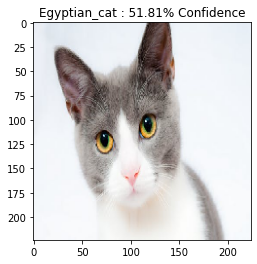

In [55]:
plt.imshow(tf.keras.preprocessing.image.load_img('cat.jpg', target_size=(224, 224)))
plt.title('{} : {:.2f}% Confidence'.format(lab, conf*100))
plt.show

In [56]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def get_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

285


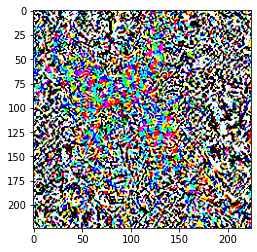

In [57]:
# Get the input label of the image.
label_index = pred.argmax()
print(label_index)
label = tf.one_hot(label_index, pred.shape[-1])
label = tf.reshape(label, (1, pred.shape[-1]))

perturbations_true = get_adversarial_pattern(img, label)
#print(perturbations_true[0] * 0.5 + 0.5)
plt.imshow(perturbations_true[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]

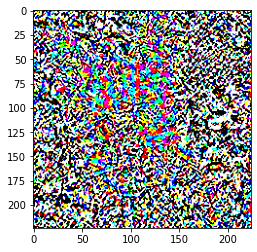

In [61]:
#index for tabby class = 281
target_label_index = 281
target_label = tf.one_hot(target_label_index, pred.shape[-1])
target_label = tf.reshape(target_label, (1, pred.shape[-1]))

perturbations_target = get_adversarial_pattern(img, target_label)
#print(perturbations_target[0] * 0.5 + 0.5)
plt.imshow(perturbations_target[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]

In [59]:
def display_images(image, description):
  pred = model.predict(image)
  lab = decode_predictions(pred,top=1)[0][0][1]
  conf = decode_predictions(pred,top=1)[0][0][2]
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.4f}% Confidence'.format(description, lab, conf*100))
  plt.show()

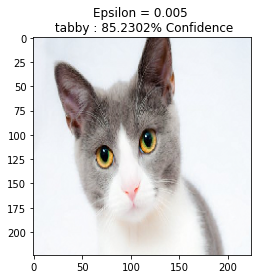

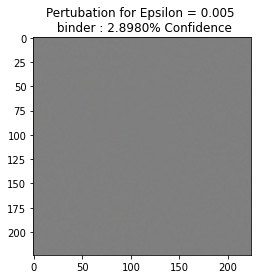

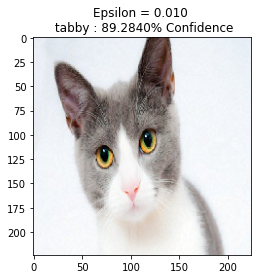

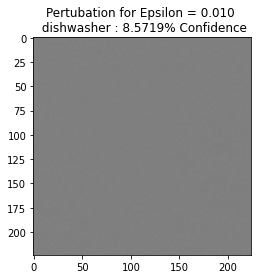

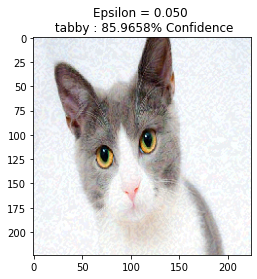

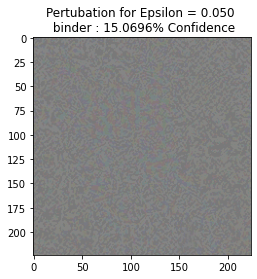

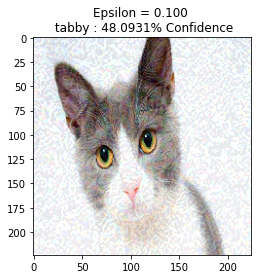

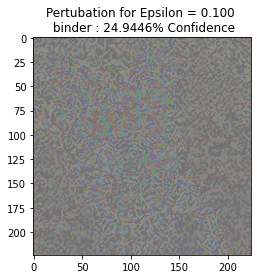

In [65]:
epsilons = [0.005, 0.01, 0.05, 0.1]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]
pertubation = [('Pertubation for Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = img - eps*perturbations_target
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])
  display_images(adv_x - img, pertubation[i])